[Open in Colab](https://colab.research.google.com/github/Sound-and-Music-Computing/smc-2023/blob/main/ML%20intro/Intro2ML_2023.ipynb)

# Chapter 1 - Linear Regression

This is the colab notebook for the introduction to machine learning of the course Sound & Music Computing at art university Linz in the Fall of 2023.

In this notebook we cover the following:

- A simple linear regression of a one-dimensional variable y depending on another one-dimensional variable y (y = a*x + b). Given some data of x and y, how to find good values for the weight a and the bias b?

- How to find good values for the weight a and the bias b if no closed-form solutions are allowed?

- What if the function is more complicated and no closed-form solution can be found?

- Introduction to pytorch, the machine learning library we use:
  - how to use models?
  - how to use losses?
  - how to use optimizers?
  - how to use  Datasets and Dataloaders?
  - how to implement a training loop?

- Machine learning training has lots of moving parts, models are black boxes, and the code notoriously hard to debug. How do we find a problem? Logging, visualization, evaluation.

In [1]:
%matplotlib inline
import numpy as np
import random
import time
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

In [4]:
my_tensor = [[[1,2],
              [3,4]],

             [[1,2],
              [3,4]]]
my_matrix = [[0, 1],
             [2, 3]]
my_vect = [5, 6]

## Simple Linear Regression

Let's assume we have some data points (observations) of variable x and variable y. Both are scalar-valued, that is each observation is a single number and they are measured in pairs (x_i, y_i). For convenience we are going to generate some data, but for future models, the data stems from some data collection or measurement process and often involves some kind of sanitization, encoding, or just a general process of trying to get an intuitiion for what the data looks like.

In [5]:
n_obs = 30
# n_obs samples/data points/observations of a uniformly distributed random variable X
X = np.random.rand(n_obs) * 20 - 10

# n_obs samples/data points/observations of a random variable Y that is dependent on X (true factor 0.5), but the measurement is noisy (Gaussian noise with mean 0 and variance 1 is added)
Y = 0.5 * X   + np.random.normal(0,1.3,n_obs)

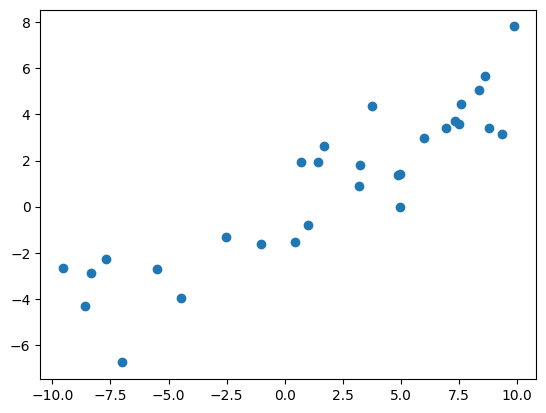

In [6]:
plt.scatter(X,Y)

In [7]:
# compute the parameters a and b with the formula (X.T * X) ^-1 * (X.T * Y)
X1=np.column_stack((np.ones(n_obs),X))
BA = np.matmul(np.linalg.inv(np.matmul(X1.T,X1)),np.matmul(X1.T,Y))
print(BA)

[0.0216544  0.50421424]


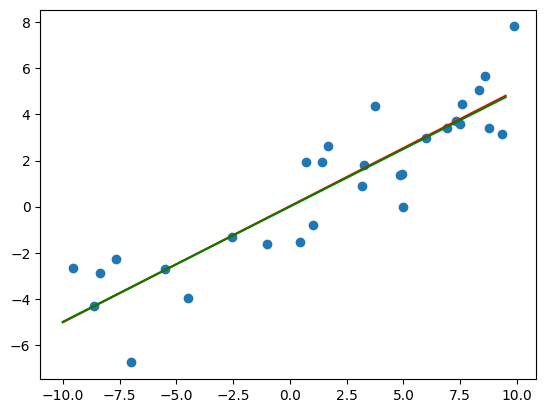

In [8]:
# plot the estimated curve
estimated_Y = BA[1]*np.arange(-10,10,0.5) + BA[0]
plt.scatter(X,Y)
plt.plot(np.arange(-10,10,0.5), estimated_Y, c ="r")
plt.plot(np.arange(-10,10,0.5), np.arange(-10,10,0.5)*0.5, c ="g")

## (Stochastic) Gradient Descent

What if we don't know (or there isn't) a nead formula like (X.T * X) ^-1 * (X.T * Y) to find the value that make the curve approximate the data?

We use gradient descent!

What we need for this:
- the problem is formulated as an optimization problem, the "curve fitting" can be represented as a quantity which has is smaller the better the curve fits. We call this quantity the "**loss**" in machine learning, and machine learning minimizes losses.

- we need to figure out how to change weight a and bias b such that the loss becomes smaller. For any given a and b, we can compute the **derivative** of the loss with respect to a and b. Intuitively, this tells us how the loss changes if we increase a a tiny little bit from its current value.

- The collection of all (partial) derivatives of a loss with respect to a models parameters (in this case weight a and bias b) is called the **gradient**. We can decrease the loss slightly, by moving the parameters in the opposite direction of the gradient.

- If we repeat this parameter adjustment by negative gradient many times, we approach a minimal value of the loss. This is called gradient descent. The individual steps are quite small, their size is given a parameter called **learning rate**. Thhe whole process is called **training**, since the steps are taken repeatedly, people also speak of a **training loop**.

Let's have look at the previous example:
- **loss** for this curve fit; the (mean) squared error of the distance between the predicted y and the true y. If the curve fits the points perfectly (which isn't possible in this case. why is that so?), this distance becomes 0. In general, the lower the distance, the better the fit, hence it is a good loss for the regression case.

loss(estimated_y,y) = (estimated_y - y) ** 2

- The **partial derivatives** are computed from the chain rule of differentiation:

dl/da = 2 * ((a * x + b) - y) * x

dl/db = 2 * ((a * x + b) - y) * 1

- To use gradient descent, we have to use initial guesses for the parameters and then successively improve them by moving them in the opposite direction of the gradient. Let's start with a = 10, b = -10

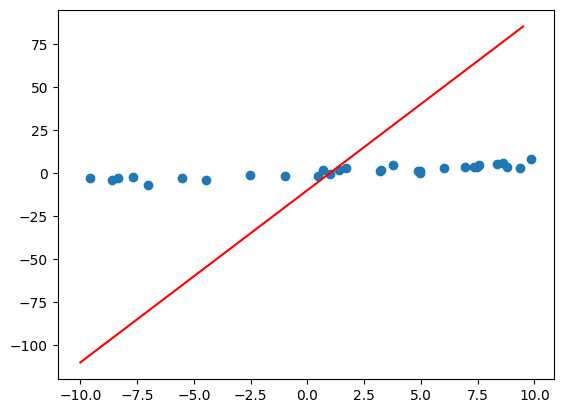

In [9]:
# let's look at the initial guess
plt.scatter(X,Y)
plt.plot(np.arange(-10,10,0.5), np.arange(-10,10,0.5)*10-10, c ="r")

In [10]:
# train the parameters a and b by repeatedly moving them in the negative gradient direction.
LEARNING_RATE = 0.0001
a, b = -10, 7
a_saved, b_saved = list(), list()
for k in range(100):
  # print("current a, b : ", a, b)
  a_saved.append(a)
  b_saved.append(b)
  for x, y in zip(X,Y):
    dlda = 2 * ((a * x + b) - y) * x
    dldb = 2 * ((a * x + b) - y) * 1

    a -= dlda*LEARNING_RATE
    b -= dldb*LEARNING_RATE * 10


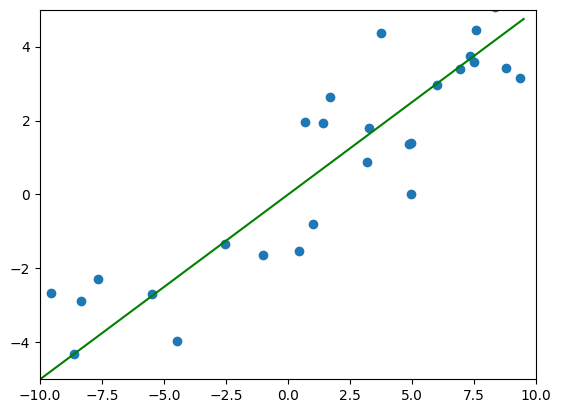

In [11]:
# plot the development of a and b and the curve they parametrize over the course of the training
fig = plt.figure()
axis = plt.axes(xlim =(-10, 10),
                ylim =(-5, 5))

axis.scatter(X,Y)
axis.plot(np.arange(-10,10,0.5), np.arange(-10,10,0.5) * 0.5, c = "g")
line, = axis.plot([], [], c = "r")

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(np.arange(-10,10,0.5), np.arange(-10,10,0.5) * a_saved[i] + b_saved[i])
    return line,

anim = FuncAnimation(fig, animate, init_func = init, frames = 100, interval = 150, blit = True)

In [12]:
anim

## Nonlinear, High-Dimensional, Multilayer Models

In many cases, we have high-dimensional input data (like images) and high-dimensional output data (like a segmentation of the image) and we want to use complicated models consisting of thousands of linear operations (like the linear regression) and nonlinear operations (which we'll see in a bit). Let's approach this by creating data that can no longer be approximated linearly and trying to fit a curve to it.

In [13]:
n_obs = 300
# n_obs samples/data points/observations of a uniformly distributed random variable X
X1 = np.random.rand(n_obs) * 20 - 10

# n_obs samples/data points/observations of a random variable Y that is dependent on X
Y1 = 5 * np.cos(np.abs(X1)**(1/3)) - 2* np.sin(X1) + np.random.normal(0,1,n_obs)

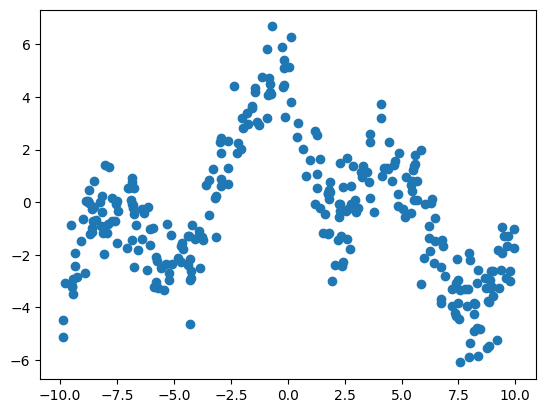

In [14]:
plt.scatter(X1,Y1)

This data is clearly unsuitable for approximation by a straight line so we have to approach by a nonlinear function. The specific nonlinear functions we are interested in have two parts:
- a linear function with weights and biases like a and b before
- a nonlinear activation function. this is an usually unparametrized function f that tranforms the input nonlinearly:

f(a) + f(b) != f(a + b)

Common examples are:

ReLU: f(x) = max(x, 0)

tanh: f(x) = tanh(x)

sigmoid: f(x) = 1 / (1 + e ** -x)

let's make an example with 2 linear functions with sigmoid activations.

In [15]:
def model(array):
  # this model has six parameters
  a, b, c, d, e, f, g = 1, 3, 10, -1, 5, -5.5, 0
  return c * 1 / (1 + np.exp(-(a * array + b))) + f * 1 / (1 + np.exp(-(d * array + e))) + g

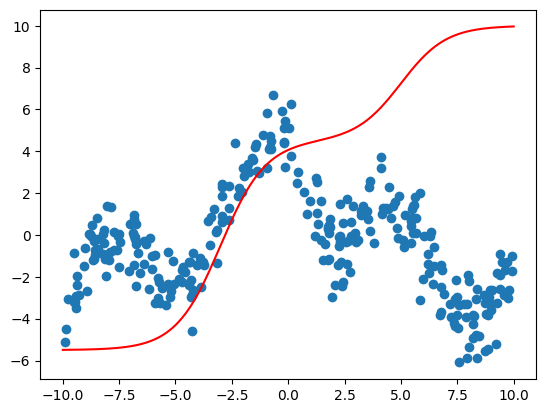

In [16]:
xs = np.linspace(-10,10,300)
plt.scatter(X1,Y1)
plt.plot(xs,model(xs), c = "r")

The curve is nonlinear but it largely fails to approximate the points. How can we use gradient descent in this case? What do the partial derivatives of all parameters a, b, c, d, e, and f look like for this model?

## Pytorch and Autograd

Luckily for us, in this and all future models that involve nonlinear functions as described above (which we'll call layer), we don't need to derive the gradient by ourselves. Instead we rely on a library called Pytorch that computes the gradient automatically, given some training data and a specification of the model in such layers.

Let's have a look at an example consisting of three building blocks:
- a dataset
- a model
- a training loop



In [17]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 4),
            nn.Sigmoid(),
            nn.Linear(4, 4),
            nn.Sigmoid(),
            nn.Linear(4, 1)
        )

    def forward(self, x):
        y = self.network(x)
        return y

In [18]:
class ScalarRegressionDataset(Dataset):
    def __init__(self,data,label):
        self.data=data
        self.label=label
    def __getitem__(self, index):
        return self.data[index],self.label[index]
    def __len__(self):
        return len(self.data)

In [19]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    test_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X.float())
        loss = loss_fn(pred, y.float())
        test_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0 and batch != 0:
            tloss, current = test_loss/100, batch * len(X)
            print(f"loss: {tloss:>7f}  [{current:>5d}/{size:>5d}]")
            test_loss = 0

After defining these classes and functions, we can put them together to train the network on the dataset (fit the model to the data, minimize the model's loss, ):

In [20]:
# initialize
dataset = ScalarRegressionDataset(X1, Y1)
dataloader = DataLoader(dataset)
model = NeuralNetwork()
loss = nn.MSELoss()
optimizer = Adam(model.parameters(),lr=0.01)

# train
for epoch in range(100):
  print("Epoch ", epoch)
  train_loop(dataloader, model, loss, optimizer)

Epoch  0
loss: 7.332751  [  100/  300]
loss: 5.078918  [  200/  300]
Epoch  1
loss: 7.114847  [  100/  300]
loss: 4.839786  [  200/  300]
Epoch  2
loss: 6.416597  [  100/  300]
loss: 4.029844  [  200/  300]
Epoch  3
loss: 5.341695  [  100/  300]
loss: 3.115648  [  200/  300]
Epoch  4
loss: 4.493494  [  100/  300]
loss: 2.488127  [  200/  300]
Epoch  5
loss: 3.996308  [  100/  300]
loss: 2.157375  [  200/  300]
Epoch  6
loss: 3.740277  [  100/  300]
loss: 2.002412  [  200/  300]
Epoch  7
loss: 3.612667  [  100/  300]
loss: 1.933682  [  200/  300]
Epoch  8
loss: 3.547818  [  100/  300]
loss: 1.903639  [  200/  300]
Epoch  9
loss: 3.513269  [  100/  300]
loss: 1.889928  [  200/  300]
Epoch  10
loss: 3.493598  [  100/  300]
loss: 1.882756  [  200/  300]
Epoch  11
loss: 3.481491  [  100/  300]
loss: 1.878075  [  200/  300]
Epoch  12
loss: 3.473428  [  100/  300]
loss: 1.874317  [  200/  300]
Epoch  13
loss: 3.467658  [  100/  300]
loss: 1.870916  [  200/  300]
Epoch  14
loss: 3.463272  [  1

In [21]:
def model_tester(model, x):
  with torch.no_grad():
    xs = torch.from_numpy(x).view(-1,1).float()
  return model(xs).detach().numpy()

In [22]:
ys = model_tester(model, xs)

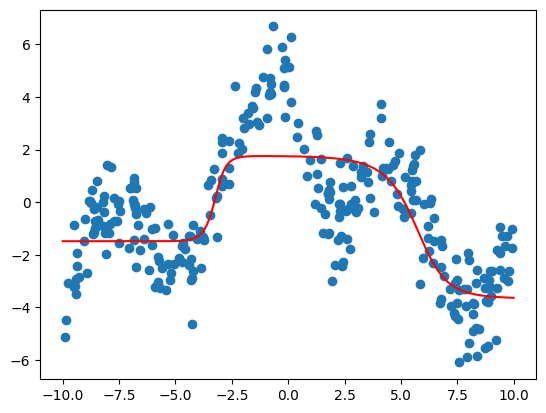

In [23]:
plt.scatter(X1,Y1)
plt.plot(xs, ys, c = "r")

In [24]:
for p in model.parameters():
  print(p)

Parameter containing:
tensor([[ 3.2108],
        [-3.1869],
        [-0.8106],
        [ 1.0093]], requires_grad=True)
Parameter containing:
tensor([ 10.0490, -10.0910,   3.9159,  -6.1454], requires_grad=True)
Parameter containing:
tensor([[-1.1175,  2.9395, -2.2072,  3.5981],
        [-1.4636,  1.2786, -3.5702,  4.7110],
        [-0.8935,  1.9151, -2.4025,  3.3758],
        [-1.3360,  3.3791, -2.0300,  3.3652]], requires_grad=True)
Parameter containing:
tensor([0.7119, 0.0653, 0.5174, 0.9843], requires_grad=True)
Parameter containing:
tensor([[-1.5188, -1.4781, -1.3413, -1.6753]], requires_grad=True)
Parameter containing:
tensor([2.0988], requires_grad=True)


#  Chapter 2 - Classification

Regression tasks are one of two major problem groups in supervised machine learning, the other being classification tasks. While regressions try to approximate one or mutliple numbers given an input data point, classifiers try to predict one or multiple class(es) the input data point belongs to. The main building blocks of the machine learning task remain the same however. In the Introduction to Machine Learning slides we separated these blocks like so:


- Data
- Labels
- Model
- Training Loop:
  - Compute Predictions from Input
  - Compare Predictions to Labels (Loss)
  - Update the Model (Optimizer, Gradient Descent)

## The Data and the Labels

First we will define our data and our labels. We again start with synthetic data; randomly generated values both for both. In the real world scenario this values will come from somewhere else. We will explore this scenario soon. Lets start by defining 1000 datapoints with 100 features each. The labels will be binary, meaning they will be either 0 or 1 in our example.

In [25]:
# (Num_datapoints, Num_features)
dist0 = torch.normal(2, 3, size=(1000, 100))
dist1 = torch.normal(0, 5, size=(1000, 100))
# Same number of datapoints for labels, high is 1 more than the highest number we want to include.
labels = torch.randint(low=0, high=2, size=(1000,))
data = dist0
data[labels==0] = dist1[labels==0]

Now let's Separate our data to a Training Set and a Test Set. We will pick the first 700 samples for training and the rest for testing. Let's rename them to `x_train`, `x_test` for the data and `y_train`, `y_test` for the labels.

In [26]:
x_train = data[:700]
x_test = data[700:]
y_train = labels[:700]
y_test = labels[700:]

## The Model

In this section we will define the model. We will use the same basic version of a Neural Network that we used for Regression called a Multi-Layer Perception or MLP. Every layer consists of a *Linear Transformation* (in torch `torch.nn.Linear(input_dims, output_dims))` followed by a *Non-Linearity* for example ReLU (in torch `torch.nn.ReLU()`.

In [27]:
class MLP(torch.nn.Module):
    '''A Multi-Layer Perceptron Model'''
    # Initialization
    def __init__(self, num_features=100, num_hidden=128, num_labels=2, num_hlayers=2):
        super(MLP, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.non_linear_activation = torch.nn.ReLU()
        # First Layer
        self.layers.append(torch.nn.Linear(num_features, num_hidden))
        for i in range(num_hlayers - 1):
            self.layers.append(torch.nn.Linear(num_hidden, num_hidden))
        self.layers.append(torch.nn.Linear(num_hidden, num_labels))

    def forward(self, x):
        '''Update Function and predict function of the model'''
        h = x
        # Iterate of layers
        for layer in self.layers[:-1]:
            h = layer(h)
            h = self.non_linear_activation(h)
        # Last layer has no activation
        h = self.layers[-1](h)
        return h

## Initialization

In this step we will Initialize the Main components of the training framework. The Model, the Loss and the Optimizer.

- Model is an MLP
- The Loss will be Binary Cross entropy more here.
- The optimizer will be ADAM

In [28]:
model = MLP(100, 128, 2, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_criterion = torch.nn.CrossEntropyLoss()
NUM_EPOCHS = 100

## Training Loop


In [29]:
for epoch in range(NUM_EPOCHS):
    y_pred = model.forward(x_train)
    loss = loss_criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    # predict
    with torch.no_grad():
        pred = model.forward(x_test)
        accuracy = (pred.argmax(dim=1) == y_test).float().mean()

        print("Epoch {:03} | Loss {:.03} | Accuracy {:.03} |".format(epoch, loss.item(), accuracy.item()))

Epoch 000 | Loss 0.679 | Accuracy 0.773 |
Epoch 001 | Loss 0.563 | Accuracy 0.937 |
Epoch 002 | Loss 0.47 | Accuracy 0.963 |
Epoch 003 | Loss 0.392 | Accuracy 0.973 |
Epoch 004 | Loss 0.324 | Accuracy 0.977 |
Epoch 005 | Loss 0.265 | Accuracy 0.977 |
Epoch 006 | Loss 0.214 | Accuracy 0.977 |
Epoch 007 | Loss 0.17 | Accuracy 0.983 |
Epoch 008 | Loss 0.133 | Accuracy 0.99 |
Epoch 009 | Loss 0.104 | Accuracy 0.99 |
Epoch 010 | Loss 0.0806 | Accuracy 0.993 |
Epoch 011 | Loss 0.0633 | Accuracy 0.993 |
Epoch 012 | Loss 0.0503 | Accuracy 0.993 |
Epoch 013 | Loss 0.0407 | Accuracy 0.993 |
Epoch 014 | Loss 0.0334 | Accuracy 0.993 |
Epoch 015 | Loss 0.0279 | Accuracy 0.993 |
Epoch 016 | Loss 0.0235 | Accuracy 0.993 |
Epoch 017 | Loss 0.0198 | Accuracy 0.993 |
Epoch 018 | Loss 0.0165 | Accuracy 0.993 |
Epoch 019 | Loss 0.0134 | Accuracy 0.993 |
Epoch 020 | Loss 0.0105 | Accuracy 0.993 |
Epoch 021 | Loss 0.0078 | Accuracy 0.993 |
Epoch 022 | Loss 0.00536 | Accuracy 0.993 |
Epoch 023 | Loss 0.0034 

# Chapter 3 - Real World Classification

[Reference Data.](https://www.kaggle.com/code/eliasdemoura/audio-classification)

- Import Audio Signals
- Spoken Digit Dataset
- Process audio samples
- Classify audio snippets to number.

In [30]:
import torch
import tarfile
from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset
import torch.nn as nn
from torch.nn import functional as F
import os
import librosa
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
import csv
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Audio
import scipy.io.wavfile as wav
import wave
from tqdm import tqdm
from sklearn.metrics import f1_score

#### Download and Visualize the Data

In [31]:
!wget https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip
!unzip /content/master.zip

--2023-10-19 14:43:55--  https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Jakobovski/free-spoken-digit-dataset/zip/refs/heads/master [following]
--2023-10-19 14:43:55--  https://codeload.github.com/Jakobovski/free-spoken-digit-dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [     <=>            ]  15.66M  17.0MB/s    in 0.9s    

2023-10-19 14:43:56 (17.0 MB/s) - ‘master.zip’ saved [16421388]

Archive:  /content/master.zip
4c3b0983b1b7f46ec5e49ca527e8e8844a81107e
   creating: fr

In [32]:
ndata_dir = '/content/free-spoken-digit-dataset-master/recordings/'
output_dir =  '/content/output'
SIZE = 256
BATCH_SIZE = 32
channels = 3
kernel = 4
stride = 1
pool = 2

#### Extract features from data

- Audio playback of samples from the dataset
- Investigate different representations, MFCCs, Chroma, Mel, STFT, etc.
- Extract features from the whole dataset and Save them to csv.

In [33]:
idx = 0

data, sr = librosa.load(os.path.join(ndata_dir, os.listdir(ndata_dir)[idx]))
print(data)
print(data.shape, sr)
Audio(data=data, rate=sr)

[-3.5186604e-05 -2.7693502e-05 -1.4156612e-06 ...  4.2545842e-04
  1.6886138e-04  0.0000000e+00]
(12663,) 22050


In [55]:
mfcc = np.mean(librosa.feature.mfcc(y = data, sr=sr).T, axis = 0)
stft = np.abs(librosa.stft(data))
chroma = np.mean(librosa.feature.chroma_stft(S = stft, sr = sr).T, axis = 0)
contrast = np.mean(librosa.feature.spectral_contrast(S = stft, sr = sr).T, axis = 0)
tonnetz = np.mean(librosa.feature.tonnetz(y = librosa.effects.harmonic(data), sr = sr).T, axis = 0)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=792
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=396
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=198
  warnings.warn(


In [35]:
image = Image.fromarray(librosa.feature.mfcc(y = data, sr=sr).T, "RGB")
display(image)

In [38]:
def extract_features(path=ndata_dir, feature="mfcc"):
    X = list()
    y = list()
    prev_viewed_speakers =list()
    print("Be patient this might take a while... \n Loading Dataset:")
    for file in tqdm(os.listdir(path)):
        if file.endswith(".wav"):
            data, sr = librosa.load(os.path.join(path, file))
            if feature == "mfcc":
                feats = np.mean(librosa.feature.mfcc(y = data, sr=sr).T, axis = 0)
            elif feature == "stft":
                feats = np.abs(librosa.stft(data))
            elif feature == "chroma":
                feats = np.mean(librosa.feature.chroma_stft(S = stft, sr = sr).T, axis = 0)
            elif feature == "mel":
                feats = np.mean(librosa.feature.melspectrogram(data, sr).T, axis = 0)
            elif feature == "contrast":
                feats = np.mean(librosa.feature.spectral_contrast(S = stft, sr = sr).T, axis = 0)
            elif feature == "tonnetz":
                feats = np.mean(librosa.feature.tonnetz(y = librosa.effects.harmonic(data), sr = sr).T, axis = 0)
            else:
                raise ValueError("Feature {} does not exist".format(feature))

            # digit is the first element
            spoken_num, speaker, _ = file.split("_")
            label = eval(spoken_num)

            #print(mfccs.shape, stft.shape, chroma.shape, mel.shape, contrast.shape, tonnetz.shape)

            # row =  np.concatenate((mfccs, chroma, mel, contrast, tonnetz), axis = 0).astype('float32')
            X.append(feats)
            y.append(label)
    return np.array(X), np.array(y)

In [39]:
X, y = extract_features()
np.unique(y)

Be patient this might take a while... 
 Loading Dataset:


100%|██████████| 3000/3000 [00:18<00:00, 165.94it/s]


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#### Create Dataloaders



In [40]:
spokendset = TensorDataset(torch.tensor(X),torch.tensor(y))
size = len(spokendset)
val_size = int(0.1 * size)
train_size = size - val_size

train_dset, val_dset = random_split(spokendset, [train_size, val_size])

train_size, val_size
train_dl = DataLoader(train_dset, BATCH_SIZE, True)
val_dl = DataLoader(val_dset, BATCH_SIZE)

#### Create Model

The model always at least has three arguments:
1. Input Size - The input size of your features
2. Hidden Size the size of the hidden layers
3. Number of Classes - The number of Classes to predict(for spoken digits is 10 for speakers is 4).

In [41]:
class SpokenDigitModel(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_classes=10):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.l3 = nn.Linear(int(hidden_size/2), int(hidden_size/4))
        self.l4 = nn.Linear(int(hidden_size/4), num_classes)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        return x

    def training_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        return loss

    def validation_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        _, pred = torch.max(outputs, 1)
        accuracy = torch.tensor(torch.sum(pred==labels).item()/len(pred))
        return [loss.detach(), accuracy.detach()]

In [42]:
model = SpokenDigitModel(10, 10, 10)

In [43]:
def evaluate(model, loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in loader]
    outputs = torch.tensor(outputs).T
    loss, accuracy = torch.mean(outputs, dim=1)
    return {"loss" : loss.item(), "accuracy" : accuracy.item()}


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(model, train_loader, val_loader, epochs, lr, optimizer_function = torch.optim.Adam):
    history = []
    optimizer = optimizer_function(model.parameters(), lr)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        print("Epoch ", epoch)
        #Train
        model.train()
        lrs = []
        tr_loss = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            tr_loss.append(loss)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
        #Validate
        result = evaluate(model, val_loader)
        result["lrs"] = lrs
        result["train loss"] = torch.stack(tr_loss).mean().item()

        print("Last lr: ", lrs[-1]," Train_loss: ", result["train loss"], " Val_loss: ", result['loss'], " Accuracy: ", result['accuracy'])
        history.append(result)
    return history




### Train The Model

In [47]:
model = SpokenDigitModel(input_size=X.shape[1], num_classes = len(np.unique(y)))
history = []
evaluate(model, val_dl)


{'loss': 3.4098639488220215, 'accuracy': 0.07187499850988388}

In [48]:
history.append(fit(model, train_dl, val_dl, 64, 0.01))

Epoch  0


100%|██████████| 85/85 [00:00<00:00, 622.32it/s]


Last lr:  0.0004626922687349655  Train_loss:  2.0133097171783447  Val_loss:  1.6852056980133057  Accuracy:  0.3552083373069763
Epoch  1


100%|██████████| 85/85 [00:00<00:00, 622.32it/s]


Last lr:  0.0006520798061317168  Train_loss:  1.394262671470642  Val_loss:  1.3483004570007324  Accuracy:  0.5166667103767395
Epoch  2


100%|██████████| 85/85 [00:00<00:00, 650.96it/s]


Last lr:  0.0009631061518648332  Train_loss:  1.032740831375122  Val_loss:  0.7748473882675171  Accuracy:  0.7302082777023315
Epoch  3


100%|██████████| 85/85 [00:00<00:00, 633.58it/s]


Last lr:  0.0013874525860704066  Train_loss:  0.8288751840591431  Val_loss:  0.5750969648361206  Accuracy:  0.8020833134651184
Epoch  4


100%|██████████| 85/85 [00:00<00:00, 663.02it/s]


Last lr:  0.0019137695264386766  Train_loss:  0.5997251272201538  Val_loss:  0.7200249433517456  Accuracy:  0.7364583015441895
Epoch  5


100%|██████████| 85/85 [00:00<00:00, 528.42it/s]


Last lr:  0.002527980084478949  Train_loss:  0.6973287463188171  Val_loss:  0.5494590997695923  Accuracy:  0.7770832777023315
Epoch  6


100%|██████████| 85/85 [00:00<00:00, 458.93it/s]


Last lr:  0.003213656566396518  Train_loss:  0.5480433702468872  Val_loss:  0.4068823754787445  Accuracy:  0.8447917103767395
Epoch  7


100%|██████████| 85/85 [00:00<00:00, 476.59it/s]


Last lr:  0.003952459848677923  Train_loss:  0.3883419632911682  Val_loss:  0.4035058915615082  Accuracy:  0.8677083253860474
Epoch  8


100%|██████████| 85/85 [00:00<00:00, 471.14it/s]


Last lr:  0.004724629876832129  Train_loss:  0.4510415494441986  Val_loss:  0.33969002962112427  Accuracy:  0.8895832896232605
Epoch  9


100%|██████████| 85/85 [00:00<00:00, 480.30it/s]


Last lr:  0.005509514168393774  Train_loss:  0.3868394196033478  Val_loss:  0.4709528982639313  Accuracy:  0.8229166865348816
Epoch  10


100%|██████████| 85/85 [00:00<00:00, 491.52it/s]


Last lr:  0.006286120184831464  Train_loss:  0.36443355679512024  Val_loss:  0.5581954717636108  Accuracy:  0.7833333015441895
Epoch  11


100%|██████████| 85/85 [00:00<00:00, 492.21it/s]

Last lr:  0.007033676798605688  Train_loss:  0.3775746822357178  Val_loss:  0.47465309500694275  Accuracy:  

0.824999988079071
Epoch  12


100%|██████████| 85/85 [00:00<00:00, 470.27it/s]

Last lr: 

 0.007732189838361804  Train_loss:  0.4842900037765503  Val_loss:  0.5515983700752258  Accuracy:  0.8062499761581421
Epoch  13


100%|██████████| 85/85 [00:00<00:00, 447.04it/s]


Last lr:  0.008362976853629835  Train_loss:  0.48319944739341736  Val_loss:  0.5056370496749878  Accuracy:  0.8177083134651184
Epoch  14


100%|██████████| 85/85 [00:00<00:00, 545.73it/s]


Last lr:  0.00890916679619862  Train_loss:  0.486061155796051  Val_loss:  0.46686381101608276  Accuracy:  0.8260416984558105
Epoch  15


100%|██████████| 85/85 [00:00<00:00, 649.22it/s]


Last lr:  0.009356151253671447  Train_loss:  0.4338943362236023  Val_loss:  0.4146087169647217  Accuracy:  0.84375
Epoch  16


100%|██████████| 85/85 [00:00<00:00, 671.49it/s]


Last lr:  0.009691975166497098  Train_loss:  0.536336362361908  Val_loss:  0.44155845046043396  Accuracy:  0.8531249761581421
Epoch  17


100%|██████████| 85/85 [00:00<00:00, 709.19it/s]


Last lr:  0.009907656578347045  Train_loss:  0.527778148651123  Val_loss:  0.44015073776245117  Accuracy:  0.8302083015441895
Epoch  18


100%|██████████| 85/85 [00:00<00:00, 640.42it/s]


Last lr:  0.009997426867785687  Train_loss:  0.4065406322479248  Val_loss:  0.37679728865623474  Accuracy:  0.8708332777023315
Epoch  19


100%|██████████| 85/85 [00:00<00:00, 650.60it/s]


Last lr:  0.009992134106552784  Train_loss:  0.47049304842948914  Val_loss:  0.2370787113904953  Accuracy:  0.9260417222976685
Epoch  20


100%|██████████| 85/85 [00:00<00:00, 654.80it/s]


Last lr:  0.009960221326213456  Train_loss:  0.3545789420604706  Val_loss:  0.5396410226821899  Accuracy:  0.8125
Epoch  21


100%|██████████| 85/85 [00:00<00:00, 669.77it/s]


Last lr:  0.009903926786310545  Train_loss:  0.3527825176715851  Val_loss:  0.5020332336425781  Accuracy:  0.8802083134651184
Epoch  22


100%|██████████| 85/85 [00:00<00:00, 691.97it/s]


Last lr:  0.009823527201405897  Train_loss:  0.382422536611557  Val_loss:  0.32095324993133545  Accuracy:  0.8604167103767395
Epoch  23


100%|██████████| 85/85 [00:00<00:00, 636.53it/s]


Last lr:  0.009719417773875232  Train_loss:  0.3135644197463989  Val_loss:  0.4178311824798584  Accuracy:  0.8822916746139526
Epoch  24


100%|██████████| 85/85 [00:00<00:00, 656.53it/s]


Last lr:  0.009592110251299626  Train_loss:  0.3434942066669464  Val_loss:  0.30509570240974426  Accuracy:  0.9229167103767395
Epoch  25


100%|██████████| 85/85 [00:00<00:00, 640.44it/s]


Last lr:  0.009442230410981642  Train_loss:  0.30569231510162354  Val_loss:  0.26034432649612427  Accuracy:  0.9229167103767395
Epoch  26


100%|██████████| 85/85 [00:00<00:00, 657.99it/s]


Last lr:  0.009270514983950873  Train_loss:  0.36269450187683105  Val_loss:  0.29032957553863525  Accuracy:  0.9104167222976685
Epoch  27


100%|██████████| 85/85 [00:00<00:00, 660.21it/s]


Last lr:  0.009077808033578922  Train_loss:  0.34671103954315186  Val_loss:  0.5357063412666321  Accuracy:  0.84375
Epoch  28


100%|██████████| 85/85 [00:00<00:00, 668.81it/s]


Last lr:  0.008865056806604618  Train_loss:  0.25314924120903015  Val_loss:  0.2525036633014679  Accuracy:  0.9416667222976685
Epoch  29


100%|██████████| 85/85 [00:00<00:00, 658.16it/s]


Last lr:  0.008633307076963696  Train_loss:  0.2185121476650238  Val_loss:  0.18916073441505432  Accuracy:  0.9416667222976685
Epoch  30


100%|██████████| 85/85 [00:00<00:00, 687.48it/s]


Last lr:  0.00838369800531021  Train_loss:  0.26077088713645935  Val_loss:  0.272786408662796  Accuracy:  0.9145833253860474
Epoch  31


100%|██████████| 85/85 [00:00<00:00, 704.78it/s]


Last lr:  0.008117456539497631  Train_loss:  0.27392083406448364  Val_loss:  0.3199635148048401  Accuracy:  0.9145833253860474
Epoch  32


100%|██████████| 85/85 [00:00<00:00, 601.58it/s]


Last lr:  0.007835891383543871  Train_loss:  0.2201836109161377  Val_loss:  0.37658870220184326  Accuracy:  0.9145833253860474
Epoch  33


100%|██████████| 85/85 [00:00<00:00, 665.36it/s]


Last lr:  0.007540386564725742  Train_loss:  0.1601148545742035  Val_loss:  0.1886567920446396  Accuracy:  0.9416667222976685
Epoch  34


100%|██████████| 85/85 [00:00<00:00, 668.41it/s]


Last lr:  0.007232394630423575  Train_loss:  0.1976136416196823  Val_loss:  0.3971024453639984  Accuracy:  0.9114583134651184
Epoch  35


100%|██████████| 85/85 [00:00<00:00, 655.47it/s]


Last lr:  0.006913429508156802  Train_loss:  0.18030200898647308  Val_loss:  0.4215462803840637  Accuracy:  0.925000011920929
Epoch  36


100%|██████████| 85/85 [00:00<00:00, 657.90it/s]


Last lr:  0.006585059063906825  Train_loss:  0.14642122387886047  Val_loss:  0.1673416793346405  Accuracy:  0.9479166865348816
Epoch  37


100%|██████████| 85/85 [00:00<00:00, 680.76it/s]


Last lr:  0.006248897395306571  Train_loss:  0.1152259036898613  Val_loss:  0.18082305788993835  Accuracy:  0.9593750238418579
Epoch  38


100%|██████████| 85/85 [00:00<00:00, 703.87it/s]


Last lr:  0.005906596897579397  Train_loss:  0.10661593079566956  Val_loss:  0.7310889363288879  Accuracy:  0.8864582777023315
Epoch  39


100%|██████████| 85/85 [00:00<00:00, 617.97it/s]


Last lr:  0.005559840141227017  Train_loss:  0.16028344631195068  Val_loss:  0.2503945231437683  Accuracy:  0.9437500238418579
Epoch  40


100%|██████████| 85/85 [00:00<00:00, 671.31it/s]


Last lr:  0.005210331601391556  Train_loss:  0.11907707899808884  Val_loss:  0.23476214706897736  Accuracy:  0.9364582896232605
Epoch  41


100%|██████████| 85/85 [00:00<00:00, 652.41it/s]


Last lr:  0.004859789279545781  Train_loss:  0.09207142889499664  Val_loss:  0.18898160755634308  Accuracy:  0.9395833015441895
Epoch  42


100%|██████████| 85/85 [00:00<00:00, 679.90it/s]


Last lr:  0.004509936258695003  Train_loss:  0.0926508754491806  Val_loss:  0.1790076643228531  Accuracy:  0.9572917222976685
Epoch  43


100%|██████████| 85/85 [00:00<00:00, 665.41it/s]


Last lr:  0.004162492233600785  Train_loss:  0.08046507835388184  Val_loss:  0.20469066500663757  Accuracy:  0.9447916746139526
Epoch  44


100%|██████████| 85/85 [00:00<00:00, 681.97it/s]


Last lr:  0.0038191650576594933  Train_loss:  0.061973027884960175  Val_loss:  0.16272039711475372  Accuracy:  0.96875
Epoch  45


100%|██████████| 85/85 [00:00<00:00, 652.15it/s]


Last lr:  0.003481642347986829  Train_loss:  0.04669534042477608  Val_loss:  0.16903910040855408  Accuracy:  0.9666666984558105
Epoch  46


100%|██████████| 85/85 [00:00<00:00, 634.85it/s]


Last lr:  0.0031515831899733408  Train_loss:  0.03290416672825813  Val_loss:  0.2159493863582611  Accuracy:  0.9458333253860474
Epoch  47


100%|██████████| 85/85 [00:00<00:00, 662.23it/s]


Last lr:  0.0028306099820869924  Train_loss:  0.025775084272027016  Val_loss:  0.18387609720230103  Accuracy:  0.9635416865348816
Epoch  48


100%|██████████| 85/85 [00:00<00:00, 669.98it/s]


Last lr:  0.0025203004610094945  Train_loss:  0.049891579896211624  Val_loss:  0.23084035515785217  Accuracy:  0.9541667103767395
Epoch  49


100%|██████████| 85/85 [00:00<00:00, 600.77it/s]


Last lr:  0.002222179946306651  Train_loss:  0.029878195375204086  Val_loss:  0.2039368599653244  Accuracy:  0.9604166746139526
Epoch  50


100%|██████████| 85/85 [00:00<00:00, 674.96it/s]


Last lr:  0.0019377138427538756  Train_loss:  0.025046365335583687  Val_loss:  0.17605367302894592  Accuracy:  0.9635416865348816
Epoch  51


100%|██████████| 85/85 [00:00<00:00, 671.87it/s]


Last lr:  0.0016683004371715396  Train_loss:  0.02015547640621662  Val_loss:  0.18987351655960083  Accuracy:  0.9635416865348816
Epoch  52


100%|██████████| 85/85 [00:00<00:00, 696.40it/s]


Last lr:  0.0014152640251771198  Train_loss:  0.016514861956238747  Val_loss:  0.1861727237701416  Accuracy:  0.9666666984558105
Epoch  53


100%|██████████| 85/85 [00:00<00:00, 616.44it/s]


Last lr:  0.001179848401639479  Train_loss:  0.012144487351179123  Val_loss:  0.2273688018321991  Accuracy:  0.9635416865348816
Epoch  54


100%|██████████| 85/85 [00:00<00:00, 683.57it/s]


Last lr:  0.0009632107468327899  Train_loss:  0.012424502521753311  Val_loss:  0.20075564086437225  Accuracy:  0.9635416865348816
Epoch  55


100%|██████████| 85/85 [00:00<00:00, 668.08it/s]


Last lr:  0.0007664159383425639  Train_loss:  0.010191280394792557  Val_loss:  0.1976630836725235  Accuracy:  0.9635416865348816
Epoch  56


100%|██████████| 85/85 [00:00<00:00, 677.31it/s]


Last lr:  0.0005904313166835123  Train_loss:  0.008935915306210518  Val_loss:  0.20828552544116974  Accuracy:  0.9635416865348816
Epoch  57


100%|██████████| 85/85 [00:00<00:00, 697.70it/s]


Last lr:  0.0004361219303587067  Train_loss:  0.008607435040175915  Val_loss:  0.2091474086046219  Accuracy:  0.9635416865348816
Epoch  58


100%|██████████| 85/85 [00:00<00:00, 643.98it/s]


Last lr:  0.0003042462837328597  Train_loss:  0.008038204163312912  Val_loss:  0.2150026261806488  Accuracy:  0.9635416865348816
Epoch  59


100%|██████████| 85/85 [00:00<00:00, 607.58it/s]


Last lr:  0.00019545260862094147  Train_loss:  0.007768241222947836  Val_loss:  0.2117125689983368  Accuracy:  0.9635416865348816
Epoch  60


100%|██████████| 85/85 [00:00<00:00, 598.41it/s]


Last lr:  0.00011027567791908655  Train_loss:  0.007317753508687019  Val_loss:  0.21191108226776123  Accuracy:  0.9635416865348816
Epoch  61


100%|██████████| 85/85 [00:00<00:00, 670.54it/s]


Last lr:  4.913417694027851e-05  Train_loss:  0.007221894338726997  Val_loss:  0.2146253138780594  Accuracy:  0.9635416865348816
Epoch  62


100%|██████████| 85/85 [00:00<00:00, 681.46it/s]


Last lr:  1.232864537599174e-05  Train_loss:  0.007110539823770523  Val_loss:  0.21453353762626648  Accuracy:  0.9635416865348816
Epoch  63


100%|██████████| 85/85 [00:00<00:00, 646.33it/s]

Last lr:  4e-08  Train_loss:  0.007125949952751398  Val_loss:  0.21461641788482666  Accuracy:  0.9635416865348816


### Predict

In [49]:
@torch.no_grad()
def predict_dl(model, dl):
    torch.cuda.empty_cache()
    batch_probs = []
    batch_targ = []
    for xb, yb in dl:
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
        batch_targ.append(yb.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    batch_targ = torch.cat(batch_targ)
    return [list(values).index(max(values)) for values in batch_probs], batch_targ

In [50]:
r = evaluate(model, val_dl)
yp, yt = predict_dl(model, val_dl)
print("Loss: ", r['loss'], "\nAccuracy: ", r['accuracy'], "\nF-score: ", f1_score(yt, yp, average='micro'))

Loss:  0.21461641788482666 
Accuracy:  0.9635416865348816 
F-score:  0.9666666666666667


In [51]:
losses = []
accuracies = []
last_lr = []
for i in history[0]:
    losses.append(i['loss'])
    accuracies.append(i['accuracy'])
    last_lr.append(i['lrs'][-1])

def plot(var, title):
    plt.plot(var, '-x')
    plt.title(title)

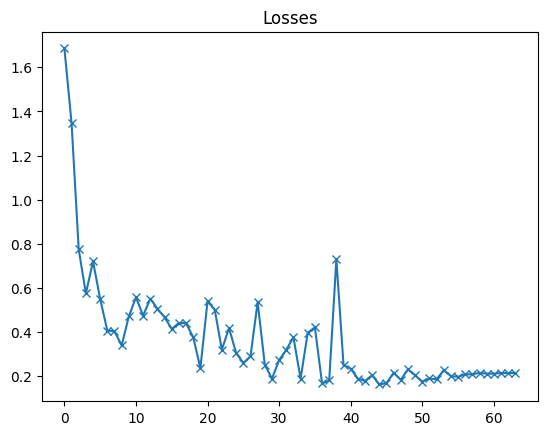

In [52]:
plot(losses, 'Losses')

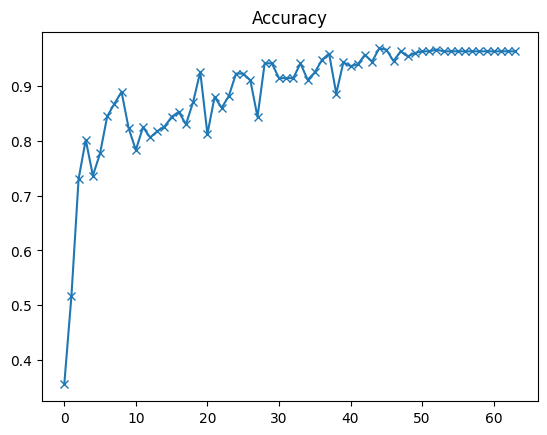

In [53]:
plot(accuracies, 'Accuracy')

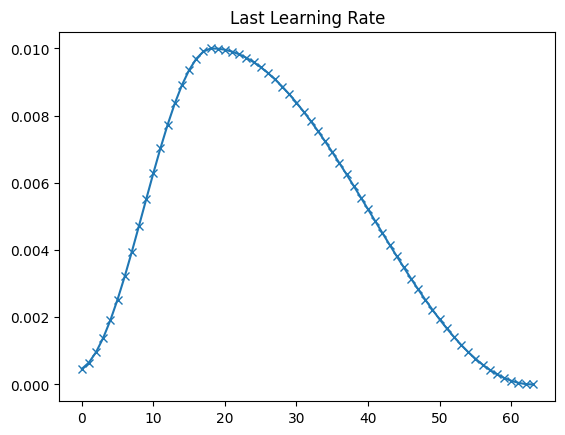

In [54]:
plot(last_lr, 'Last Learning Rate')

# Now is your Turn!

Take our example for spoken digit classification and try to classify who is speaking instead. Remember to try different audio features and to encode any not arithmetic input such as speaker names.